#2.2.  Para los modelos estudiados en el punto 2.1, presente el entrenamiento y evaluación de los mismos sobre la base de datos Fashion Mnist. Discuta los resultados obtenidos y los tips de entrenamiento utilizados en cada caso para facilitar la convergencia de cada uno de los métodos

**Descripción del Cuaderno**

Este cuaderno está diseñado para trabajar con modelos de aprendizaje automático utilizando TensorFlow y otras bibliotecas relevantes.

1. **Instalación y Configuración**: Desinstala versiones anteriores de TensorFlow y `tf-keras` e instala TensorFlow 2.15.0.

2. **Importación de Librerías**: Incluye `sklearn` para herramientas de machine learning, `tensorflow` y `keras` para aprendizaje profundo, `numpy` para operaciones numéricas, `os` para manejo de archivos, y `matplotlib` para visualización.

3. **Configuración del Entorno**: Establece semillas para reproducibilidad y configura Matplotlib para mostrar gráficos en línea con tamaños de fuente específicos.

4. **Configuración de Directorios y Funciones para Guardar Figuras**: Define el directorio para guardar imágenes y funciones para guardar figuras y trazar imágenes.

5. **Carga y Preprocesamiento de Datos**: Carga el conjunto de datos Fashion MNIST, normaliza los valores de los píxeles y divide el conjunto de entrenamiento en datos de entrenamiento y validación.

6. **Definición de Métricas y Funciones de Ajuste de Tasa de Aprendizaje**: Incluye una métrica personalizada para precisión redondeada y funciones para ajustar la tasa de aprendizaje.

7. **Funciones para Visualización de Reconstrucciones**: Visualiza las reconstrucciones generadas por el modelo comparadas con las imágenes originales.

8. **Evaluación de Modelos**: Evalúa el modelo en el conjunto de prueba y muestra gráficos de pérdida y precisión durante el entrenamiento.

9. **Definición de Clases y Funciones para Autoencoders Variacionales**: Incluye una función de pérdida escalada y una capa de muestreo para autoencoders variacionales.

10. **Evaluación Avanzada del Discriminador**: Evalúa el discriminador de un GAN generando imágenes falsas y reales, y calcula métricas de rendimiento como la curva ROC y la matriz de confusión.

11. **Instalación de Paquetes Adicionales**: Instala paquetes adicionales para la generación de GIFs y documentación de TensorFlow.

In [1]:
!pip uninstall -y tensorflow tf-keras
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully u

In [7]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

# Configuración de semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Configuración para la visualización de gráficos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ruta para guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """Guarda la figura en el directorio especificado."""
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    """Muestra una imagen en blanco y negro."""
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Carga y preprocesamiento de los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

def rounded_accuracy(y_true, y_pred):
    """Calcula la precisión redondeada."""
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

def piecewise_constant_fn(epoch):
    """Devuelve una tasa de aprendizaje adaptativa basada en el número de épocas."""
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

def piecewise_constant(boundaries, values):
    """Devuelve una función de tasa de aprendizaje adaptativa basada en límites y valores."""
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

def show_reconstructions(model, images=X_valid, n_images=5):
    """Muestra reconstrucciones de imágenes generadas por el modelo."""
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def evaluar_modelo(history, model, X_test):
    """Evalúa el modelo y genera gráficos de pérdida y precisión durante el entrenamiento."""
    resultado = model.evaluate(X_test, X_test, verbose=0)
    print(f'Evaluación con test: Loss= {resultado[0]}, Acc= {resultado[1]}')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Error')
    plt.legend()

    if 'rounded_accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['rounded_accuracy'], label='Acc')
        plt.plot(history.history['val_rounded_accuracy'], label='Val Acc')
        plt.title('Precisión durante el entrenamiento')
        plt.xlabel('Épocas')
        plt.ylabel('Acc')
        plt.legend()

    plt.show()

class ScaledBinaryCrossentropy(keras.losses.Loss):
    """Pérdida de entropía cruzada binaria escalada."""
    def __init__(self, scale):
        super(ScaledBinaryCrossentropy, self).__init__()
        self.scale = scale

    def call(self, y_true, y_pred):
        return self.scale * tf.keras.losses.mae(y_true, y_pred)

class Sampling(keras.layers.Layer):
    """Capa de muestreo para un autoencoder variacional."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def show_reconstructionsve(model, images=X_valid, n_images=5):
    """Muestra reconstrucciones de imágenes generadas por el modelo variacional."""
    reconstructions = model.predict(images[:n_images])['reconstruction']
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_multiple_imagesve(images, n_cols=None):
    """Muestra múltiples imágenes en una cuadrícula."""
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def evaluar_modelova(history, model, X_test):
    """Evalúa el modelo y genera gráficos de pérdida y precisión durante el entrenamiento para el autoencoder variacional."""
    resultado = model.evaluate(X_test, {"reconstruction": X_test, "dkl_loss": np.zeros((X_test.shape[0],))}, verbose=0)
    print(f'Evaluación con test: Reconstruction Loss= {resultado[1]}, DKL Loss= {resultado[2]}, Acc= {resultado[3]}')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(history.history['val_reconstruction_loss'], label='Val Reconstruction Loss')
    plt.plot(history.history['dkl_loss_loss'], label='DKL Loss')
    plt.plot(history.history['val_dkl_loss_loss'], label='Val DKL Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Error')
    plt.legend()

    if 'reconstruction_rounded_accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['reconstruction_rounded_accuracy'], label='Acc')
        plt.plot(history.history['val_reconstruction_rounded_accuracy'], label='Val Acc')
        plt.title('Precisión durante el entrenamiento')
        plt.xlabel('Épocas')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

# Instalación de paquetes necesarios para generar GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
import tensorflow.keras.backend as K
import glob
import imageio
import PIL
from tensorflow.keras import layers
import time
from IPython import display

# Función para calcular la pérdida de entropía cruzada
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def plot_lossesve(gen_losses, disc_losses):
    """Muestra la pérdida del generador y del discriminador durante el entrenamiento."""
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Loss During Training')
    plt.show()

from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

def evaluate_discriminator(test_images, generator, discriminator, noise_dim):
    # Generar imágenes falsas con el mismo tamaño que el conjunto de datos de prueba
    noise = tf.random.normal([test_images.shape[0], noise_dim])
    generated_images = generator(noise, training=False)

    # Obtener las salidas del discriminador
    real_output = discriminator(test_images, training=False)
    fake_output = discriminator(generated_images, training=False)

    # Etiquetas verdaderas: 1 para reales, 0 para falsas
    y_true = np.array([1] * test_images.shape[0] + [0] * generated_images.shape[0])

    # Predicciones del discriminador (1 si > 0.5, 0 si <= 0.5)
    y_pred = np.concatenate([real_output > 0.5, fake_output > 0.5]).astype(int)
    y_scores = np.concatenate([real_output, fake_output])  # Obtener las probabilidades para la curva ROC

    # Calcular la curva ROC y el AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Calcular la matriz de confusión normalizada
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

    # Configuración de la figura con dos gráficos (ROC y matriz de confusión)
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 8))

    # Graficar la curva ROC
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    # Graficar la matriz de confusión normalizada
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Falsas", "Reales"])
    disp.plot(cmap=plt.cm.Blues, ax=ax2, colorbar=True)
    ax2.set_title('Normalized Confusion Matrix')

    plt.show()

    # Calcular las métricas y generar el reporte de clasificación
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)

    # Imprimir las métricas de precisión, recall y F2-score
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2-score: {f2:.4f}")

    # Generar e imprimir el reporte de clasificación después de la matriz de confusión
    report = classification_report(y_true, y_pred, target_names=["Falsas", "Reales"])
    print(report)


(_, _), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normaliza las imágenes a [-1, 1]
# Llama esta función después de entrenar el modelo



  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-thfj_vit
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-thfj_vit
  Resolved https://github.com/tensorflow/docs to commit 460419a6369bd00bfc3ce7a7c92b0ca2a832c91b
  Preparing metadata (setup.py) ... done


## Autoencoder

**Descripción del Código**

1. **Planificador de Tasa de Aprendizaje**:
   - Se define una función `piecewise_constant_fn` que ajusta la tasa de aprendizaje a lo largo del entrenamiento utilizando la función `piecewise_constant` con los valores `[40, 18]` y las tasas `[1e-3, 1e-4]`.
   - Se crea un `LearningRateScheduler` de Keras con esta función para modificar la tasa de aprendizaje durante el entrenamiento.

2. **Configuración de Aleatoriedad**:
   - Se establecen semillas fijas para TensorFlow y NumPy (`42`) para asegurar la reproducibilidad de los resultados.

3. **Definición del Autoencoder**:
   - **Codificador** (`stacked_encoder`): Un modelo secuencial que aplanará las imágenes, aplicará capas densas con activación "selu" y normalización por lotes.
   - **Decodificador** (`stacked_decoder`): Un modelo secuencial que aplicará normalización por lotes, capas densas y finalmente reconstruirá la imagen en su forma original utilizando una activación "sigmoid".

4. **Compilación y Entrenamiento del Autoencoder**:
   - Se crea un modelo de autoencoder (`stacked_ae`) que combina el codificador y el decodificador.
   - El modelo se compila utilizando la pérdida "huber", el optimizador 'adam', y una métrica personalizada de precisión redondeada.
   - El modelo se entrena en el conjunto de entrenamiento `X_train`, validado con `X_valid`, durante 50 épocas, utilizando un tamaño de lote de 256 y el planificador de tasa de aprendizaje definido.

In [4]:
# Configuración de la función de tasa de aprendizaje adaptativa
piecewise_constant_fn = piecewise_constant([40, 18], [1e-3, 1e-4])
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# Configuración de semillas para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# Definición del encoder
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="selu"),
])

# Definición del decoder
stacked_decoder = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# Construcción del autoencoder
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

# Compilación del autoencoder
stacked_ae.compile(loss="huber",
                   optimizer='adam', metrics=[rounded_accuracy])

# Entrenamiento del autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=50,
                         validation_data=(X_valid, X_valid),
                         callbacks=[lr_scheduler],
                         batch_size=256)

Epoch 1/50
215/215 [==============================] - 18s 13ms/step - loss: 0.0129 - rounded_accuracy: 0.9157 - val_loss: 0.0071 - val_rounded_accuracy: 0.9350 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 2s 10ms/step - loss: 0.0043 - rounded_accuracy: 0.9533 - val_loss: 0.0042 - val_rounded_accuracy: 0.9524 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 2s 10ms/step - loss: 0.0033 - rounded_accuracy: 0.9601 - val_loss: 0.0034 - val_rounded_accuracy: 0.9591 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 2s 7ms/step - loss: 0.0028 - rounded_accuracy: 0.9636 - val_loss: 0.0029 - val_rounded_accuracy: 0.9626 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 1s 6ms/step - loss: 0.0025 - rounded_accuracy: 0.9660 - val_loss: 0.0025 - val_rounded_accuracy: 0.9659 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 2s 8ms/step - loss: 0.0023 - rounded_accuracy: 0.9677 - val_loss: 0.0025 - val_rounded_

### Reconstrucción y Evaluación

1/1 [==============================] - 0s 158ms/step


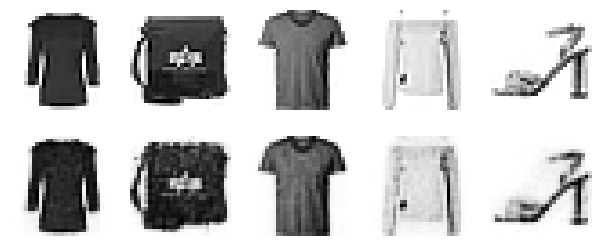

In [5]:
show_reconstructions(stacked_ae)

Evaluación con test: Loss= 0.0011946660233661532, Acc= 0.9782748818397522


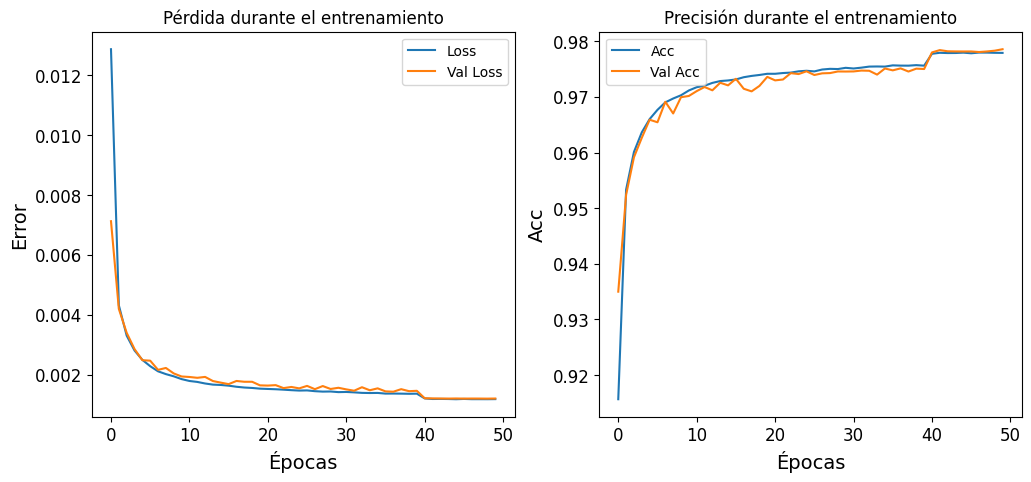

In [8]:
evaluar_modelo(history, stacked_ae, X_test)

## Autoencoder Regularizado

**Descripción del Código**

1. **Configuración de Aleatoriedad**:
   - Se establecen semillas fijas para TensorFlow y NumPy (`42`) para garantizar la reproducibilidad de los experimentos.

2. **Planificador de Tasa de Aprendizaje**:
   - Se define la función `piecewise_constant_fn` utilizando `piecewise_constant` con los puntos `[45, 30]` y las tasas `[1e-3, 1e-4]`.
   - Se crea un `LearningRateScheduler` de Keras que utiliza esta función para ajustar la tasa de aprendizaje durante el entrenamiento.

3. **Definición del Autoencoder con Regularización L1 y L2**:
   - **Codificador** (`sparse_l1l2_encoder`): Un modelo secuencial que aplana las imágenes, aplica capas densas con activación "selu" y "sigmoid", y utiliza regularización L1 y L2 en los pesos de las capas.
   - **Decodificador** (`sparse_l1l2_decoder`): Un modelo secuencial que reconstruye las imágenes desde la representación codificada utilizando capas densas con activación "selu" y "sigmoid", y también aplica regularización L1 y L2.

4. **Compilación y Entrenamiento del Autoencoder**:
   - Se crea un autoencoder (`sparse_l1l2_ae`) que combina el codificador y el decodificador.
   - El modelo se compila con la pérdida "huber", el optimizador 'adam', y una métrica personalizada de precisión redondeada.
   - Se entrena el modelo en el conjunto de entrenamiento `X_train`, validado con `X_valid`, durante 50 épocas, utilizando un tamaño de lote de 256 y el planificador de tasa de aprendizaje definido.

In [9]:

# Configuración de semillas para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# Configuración de la función de tasa de aprendizaje adaptativa
piecewise_constant_fn = piecewise_constant([45, 30], [1e-3, 1e-4])
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# Definición del encoder con regularización L1 y L2
sparse_l1l2_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(512, activation="selu", kernel_regularizer=tf.keras.regularizers.L1L2()),
    keras.layers.Dense(256, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.L1L2())
])

# Definición del decoder con regularización L1 y L2
sparse_l1l2_decoder = keras.models.Sequential([
    keras.layers.Dense(512, activation="selu", input_shape=[256], kernel_regularizer=tf.keras.regularizers.L1L2()),
    keras.layers.Dense(28 * 28, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.L1L2()),
    keras.layers.Reshape([28, 28])
])

# Construcción del autoencoder con regularización
sparse_l1l2_ae = keras.models.Sequential([sparse_l1l2_encoder, sparse_l1l2_decoder])

# Compilación del autoencoder
sparse_l1l2_ae.compile(loss="huber", optimizer='adam', metrics=[rounded_accuracy])

# Entrenamiento del autoencoder
history = sparse_l1l2_ae.fit(X_train, X_train, epochs=50,
                             validation_data=(X_valid, X_valid),
                             callbacks=[lr_scheduler],
                             batch_size=256)

Epoch 1/50
215/215 [==============================] - 5s 10ms/step - loss: 0.0167 - rounded_accuracy: 0.8871 - val_loss: 0.0098 - val_rounded_accuracy: 0.9216 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 2s 7ms/step - loss: 0.0082 - rounded_accuracy: 0.9306 - val_loss: 0.0070 - val_rounded_accuracy: 0.9367 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0063 - rounded_accuracy: 0.9409 - val_loss: 0.0058 - val_rounded_accuracy: 0.9442 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 2s 10ms/step - loss: 0.0054 - rounded_accuracy: 0.9463 - val_loss: 0.0051 - val_rounded_accuracy: 0.9480 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 3s 12ms/step - loss: 0.0047 - rounded_accuracy: 0.9501 - val_loss: 0.0045 - val_rounded_accuracy: 0.9520 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0043 - rounded_accuracy: 0.9531 - val_loss: 0.0041 - val_rounded_a

### Reconstrucción y Evaluación

1/1 [==============================] - 0s 75ms/step


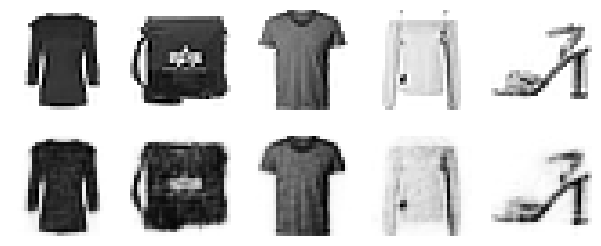

In [10]:
show_reconstructions(sparse_l1l2_ae)


Evaluación con test: Loss= 0.0014895811909809709, Acc= 0.9747119545936584


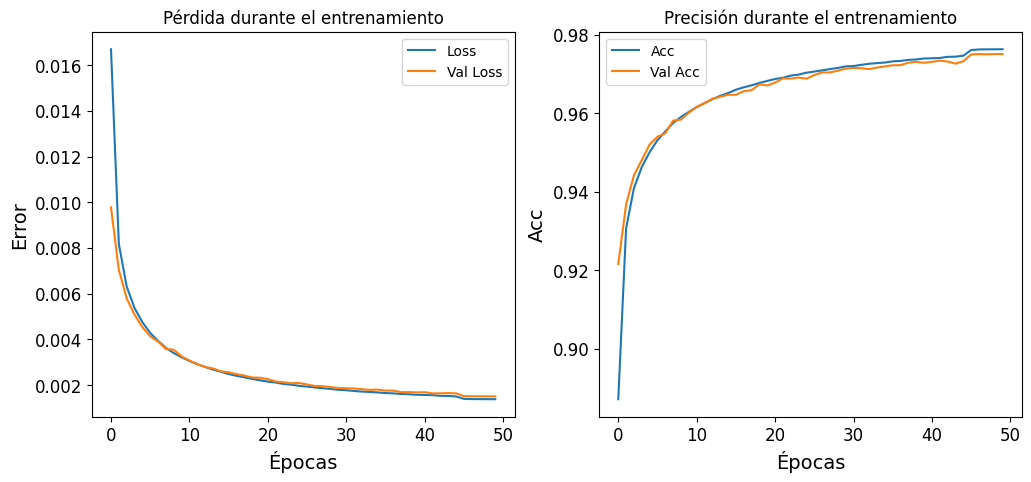

In [11]:
evaluar_modelo(history, sparse_l1l2_ae, X_test)

## Autoencoder Variacional

**Descripción del Código**

1. **Configuración Inicial**:
   - Se establecen semillas para TensorFlow y NumPy (`42`) para asegurar la reproducibilidad de los resultados.
   - Se definen los valores de `alpha` y `beta` para la función de pérdida de Kullback-Leibler (DKL), y se configura `losses` como una instancia de `ScaledBinaryCrossentropy` con un factor de escala de 5.

2. **Planificador de Tasa de Aprendizaje**:
   - Se define `piecewise_constant_fn` usando `piecewise_constant` con los puntos `[100, 30]` y tasas `[1e-3, 1e-4]`.
   - Se crea un `LearningRateScheduler` de Keras que aplica esta función para ajustar la tasa de aprendizaje durante el entrenamiento.

3. **Definición del Autoencoder Variacional**:
   - **Codificador**:
     - Se define una entrada `inputs` con forma `[28, 28]`.
     - La entrada se aplana y se pasa por capas densas con activaciones "relu" y normalización por lotes.
     - Se calculan `codings_mean` y `codings_log_var` para la distribución latente, aplicando una restricción de norma unitaria.
     - Se utiliza una capa personalizada `Sampling` para muestrear los codings a partir de la media y la varianza logarítmica.
   - **Decodificador**:
     - Se define una entrada `decoder_inputs` con forma `[codings_size]`.
     - La entrada se pasa por capas densas con activaciones "relu" y "sigmoid" para reconstruir la imagen.
     - La salida se remodela a la forma original `[28, 28]`.

4. **Modelos y Salidas**:
   - **Encoder** (`variational_encoder`): Un modelo que toma la entrada y produce `codings_mean`, `codings_log_var`, y `codings`.
   - **Decoder** (`variational_decoder`): Un modelo que toma `codings` y produce las reconstrucciones.
   - **Pérdida DKL**: Se calcula como la pérdida de Kullback-Leibler ajustada con `alpha`, y se define como una capa Lambda `dkl_loss`.

5. **Modelo Variacional Autoencoder**:
   - Se combina el codificador y el decodificador en un modelo (`variational_ae`) con dos salidas nombradas: "reconstruction" y "dkl_loss".
   - El modelo se compila con la pérdida para cada salida y el optimizador 'adam'. La métrica utilizada es la precisión redondeada para las reconstrucciones.

6. **Entrenamiento**:
   - El modelo se entrena con el conjunto de datos `X_train` y `X_valid`, durante 150 épocas, utilizando un tamaño de lote de 256 y el planificador de tasa de aprendizaje definido. La pérdida `dkl_loss` se inicializa en cero durante el entrenamiento.

In [14]:

# Configuración de semillas para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# Parámetros para la pérdida
alpha = 15
betha = 1 - alpha
losses = ScaledBinaryCrossentropy(5)

# Tamaño del espacio latente
codings_size = 300

# Configuración de la función de tasa de aprendizaje adaptativa
piecewise_constant_fn = piecewise_constant([100, 30], [1e-3, 1e-4])
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# Definición de la entrada
inputs = keras.layers.Input(shape=[28, 28], name="input")

# Encoder
z = keras.layers.Flatten(name="flatten")(inputs)
z = keras.layers.Dense(500, activation="relu")(z)
z = keras.layers.Dense(400, activation="relu")(z)
z = keras.layers.BatchNormalization()(z)
codings_mean = keras.layers.Dense(codings_size, kernel_constraint=tf.keras.constraints.UnitNorm(), name="codings_mean")(z)
codings_log_var = keras.layers.Dense(codings_size, kernel_constraint=tf.keras.constraints.UnitNorm(), name="codings_log_var")(z)
codings = Sampling(name="codings")([codings_mean, codings_log_var])

# Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size], name="decoder_input")
x = keras.layers.Dense(400, activation="relu")(decoder_inputs)
x = keras.layers.Dense(500, activation="relu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28], name="reconstruction")(x)

# Modelos
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings], name="encoder")
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs], name="reconstruction")

# Combinación del encoder y decoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

# Cálculo de la pérdida DKL
latent_loss = -alpha * 0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
dkl_output = K.mean(latent_loss) / 784.0
dkl_output = keras.layers.Lambda(lambda x: x, name="dkl_loss")(dkl_output)

# Definición del autoencoder variacional con dos salidas nombradas
variational_ae = keras.models.Model(inputs=inputs, outputs={"reconstruction": reconstructions, "dkl_loss": dkl_output})

# Compilación del modelo con pérdidas y métricas nombradas
variational_ae.compile(loss={"reconstruction": losses, "dkl_loss": lambda y_true, y_pred: y_pred},
                       optimizer="adam",
                       metrics={"reconstruction": [rounded_accuracy]})

# Entrenamiento del modelo
history = variational_ae.fit(X_train, {"reconstruction": X_train, "dkl_loss": np.zeros((X_train.shape[0],))},
                             epochs=150, batch_size=256,
                             validation_data=(X_valid, {"reconstruction": X_valid, "dkl_loss": np.zeros((X_valid.shape[0],))}),
                             callbacks=[lr_scheduler])

Epoch 1/150
215/215 [==============================] - 7s 9ms/step - loss: 0.9556 - dkl_loss_loss: 0.1234 - reconstruction_loss: 0.8321 - reconstruction_rounded_accuracy: 0.8112 - val_loss: 0.8044 - val_dkl_loss_loss: 0.1150 - val_reconstruction_loss: 0.6894 - val_reconstruction_rounded_accuracy: 0.8444 - lr: 0.0010
Epoch 2/150
215/215 [==============================] - 2s 8ms/step - loss: 0.7583 - dkl_loss_loss: 0.0931 - reconstruction_loss: 0.6652 - reconstruction_rounded_accuracy: 0.8492 - val_loss: 0.7590 - val_dkl_loss_loss: 0.1174 - val_reconstruction_loss: 0.6416 - val_reconstruction_rounded_accuracy: 0.8555 - lr: 0.0010
Epoch 3/150
215/215 [==============================] - 2s 8ms/step - loss: 0.7289 - dkl_loss_loss: 0.1002 - reconstruction_loss: 0.6286 - reconstruction_rounded_accuracy: 0.8575 - val_loss: 0.7226 - val_dkl_loss_loss: 0.1171 - val_reconstruction_loss: 0.6056 - val_reconstruction_rounded_accuracy: 0.8635 - lr: 0.0010
Epoch 4/150
215/215 [=========================

### Reconstrucción y Evaluación

1/1 [==============================] - 0s 154ms/step


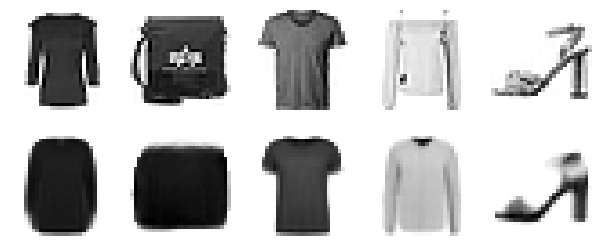

In [15]:
show_reconstructionsve(variational_ae)

Saving figure vae_generated_images_plot


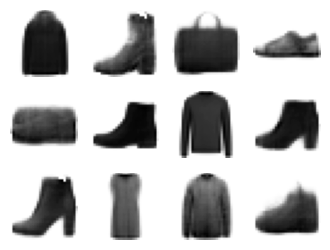

In [16]:
tf.random.set_seed(0)
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_imagesve(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Saving figure semantic_interpolation_plot


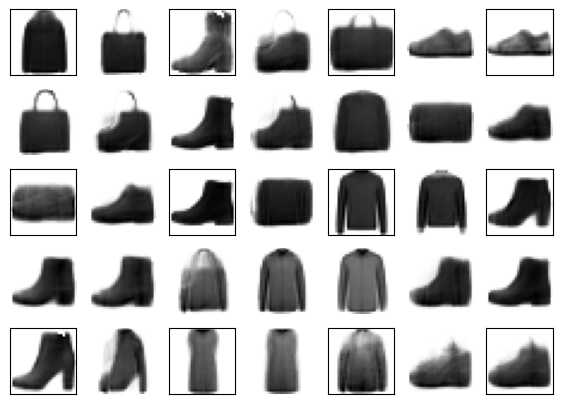

In [17]:
tf.random.set_seed(10)
np.random.seed(0)
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

Evaluación con test: Loss= 0.4974900782108307, Acc= 0.1211032122373581


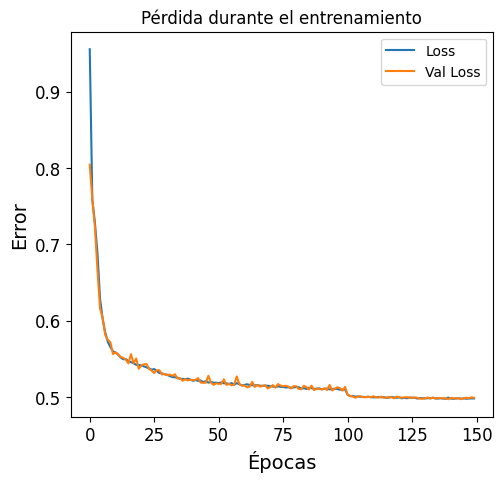

In [18]:
evaluar_modelo(history, variational_ae, X_test)

## GAN

**Descripción del Código**

1. **Preparación de Datos**:
   - Se cargan las imágenes del conjunto `fashion_mnist` y se reestructuran a una forma de `[28, 28, 1]` para incluir un canal único (escala de grises).
   - Las imágenes se normalizan a un rango de `[-1, 1]` para facilitar el entrenamiento de la red neuronal.
   - Se define el tamaño del buffer (`BUFFER_SIZE`) y el tamaño del lote (`BATCH_SIZE`).
   - Se crea un dataset de TensorFlow a partir de las imágenes, que se baraja y se divide en lotes.

2. **Modelo Generador** (`make_generator_model`):
   - Se define un modelo secuencial que genera imágenes a partir de una entrada de dimensión `256`.
   - El modelo utiliza capas `Dense`, `BatchNormalization`, y `Conv2DTranspose` para transformar la entrada en una imagen de tamaño `28x28`.
   - La arquitectura incluye varias capas de convolución transpuesta para aumentar la resolución de la imagen, con activaciones `tanh` en cada capa.

3. **Modelo Discriminador** (`make_discriminator_model`):
   - Se define un modelo secuencial que clasifica las imágenes como reales o falsas.
   - Utiliza capas `Conv2D`, `BatchNormalization`, y `LeakyReLU` para extraer características de las imágenes y reducir su tamaño.
   - La salida es una capa densa con activación `sigmoid` que predice la probabilidad de que la imagen sea real.

4. **Funciones de Pérdida**:
   - **Pérdida del Discriminador** (`discriminator_loss`): Calcula la pérdida combinada de las imágenes reales y falsas utilizando `cross_entropy`.
   - **Pérdida del Generador** (`generator_loss`): Calcula la pérdida del generador como `cross_entropy` entre las predicciones falsas y valores verdaderos (1).

5. **Generación y Guardado de Imágenes** (`generate_and_save_images`):
   - Genera imágenes usando el modelo generador y guarda las imágenes generadas en un archivo.
   - Ajusta el tamaño de la figura para acomodar un número especificado de columnas y calcula el número de filas necesarias.
   - Muestra las imágenes generadas en una cuadrícula y guarda la figura como un archivo PNG con un nombre basado en la época de entrenamiento.

In [19]:
# Cargar y preparar los datos
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizar las imágenes a [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Crear el dataset de entrenamiento con batch y shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
    """Crea el modelo del generador"""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, activation='tanh', input_shape=(256,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7, 7, 256)))

    model.add(tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(1, (2, 2), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    """Crea el modelo del discriminador"""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'sigmoid'))

    return model

def discriminator_loss(real_output, fake_output):
    """Calcula la pérdida del discriminador"""
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Calcula la pérdida del generador"""
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generate_and_save_images(model, epoch, test_input, n_cols=None):
    """Genera y guarda imágenes del modelo"""
    # Ejecutar el modelo en modo inferencia
    predictions = model(test_input, training=False)

    # Determinar el número de columnas y filas
    n_cols = n_cols or 8  # Por defecto, 8 columnas si no se especifica
    n_rows = (predictions.shape[0] - 1) // n_cols + 1

    # Ajustar el tamaño de la figura en función del número de columnas y filas
    plt.figure(figsize=(n_cols, n_rows))

    for i in range(predictions.shape[0]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

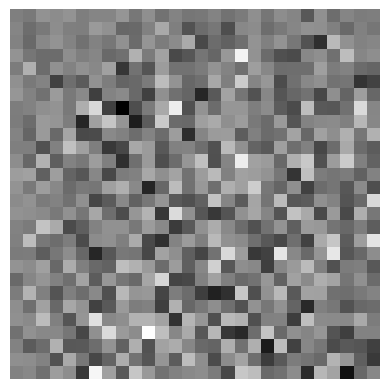

tf.Tensor([[0.49974608]], shape=(1, 1), dtype=float32)


In [20]:
# Crear el generador
generator = make_generator_model()

# Crear un vector de ruido
noise = tf.random.normal([1, 256])

# Generar una imagen
generated_image = generator(noise, training=False)

# Mostrar la imagen generada
plt.imshow(generated_image[0, :, :, 0], cmap='binary')
plt.axis('off')
plt.show()

# Crear el discriminador
discriminator = make_discriminator_model()

# Evaluar la imagen generada con el discriminador
decision = discriminator(generated_image)
print(decision)

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


**Descripción del Código**

1. **Configuración Inicial**:
   - Se definen los hiperparámetros:
     - `EPOCHS`: Número de épocas para entrenar el modelo.
     - `noise_dim`: Dimensión del ruido de entrada al generador.
     - `num_examples_to_generate`: Número de ejemplos a generar para visualizar el progreso.
   - Se establece una semilla para reproducibilidad.

2. **Inicialización de Variables**:
   - `seed`: Ruido aleatorio que se usará para visualizar el progreso de generación de imágenes.
   - `gen_losses` y `disc_losses`: Listas para almacenar las pérdidas del generador y del discriminador durante el entrenamiento.

3. **Definición del Paso de Entrenamiento**:
   - La función `train_step` realiza una iteración de entrenamiento:
     - Genera ruido aleatorio para el generador.
     - Calcula las imágenes generadas y las pasa por el discriminador.
     - Calcula las pérdidas del generador y del discriminador.
     - Calcula y aplica los gradientes a las variables del generador y del discriminador.
     - Almacena las pérdidas para su posterior visualización.

4. **Función de Entrenamiento Principal**:
   - La función `train` gestiona el proceso de entrenamiento:
     - Itera sobre el número de épocas.
     - En cada época, recorre el conjunto de datos y realiza el paso de entrenamiento.
     - Genera y guarda imágenes en cada época para visualizar el progreso.
     - Mide y muestra el tiempo transcurrido por época.
   - Después del entrenamiento, genera y guarda una última serie de imágenes.

Este código entrena un modelo generador y discriminador, y visualiza el progreso de la generación de imágenes a lo largo del tiempo.

In [22]:
# Configuración inicial
EPOCHS = 100
noise_dim = 256
num_examples_to_generate = 64

# Generar un conjunto de semillas para visualización
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Asegúrate de establecer las semillas para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# Crear listas para guardar las pérdidas
gen_losses = []
disc_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calcular los gradientes
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplicar los gradientes a los optimizadores
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Guardar las pérdidas para graficar más tarde
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Producir imágenes para el GIF a medida que avanzas
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generar imágenes después del último epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

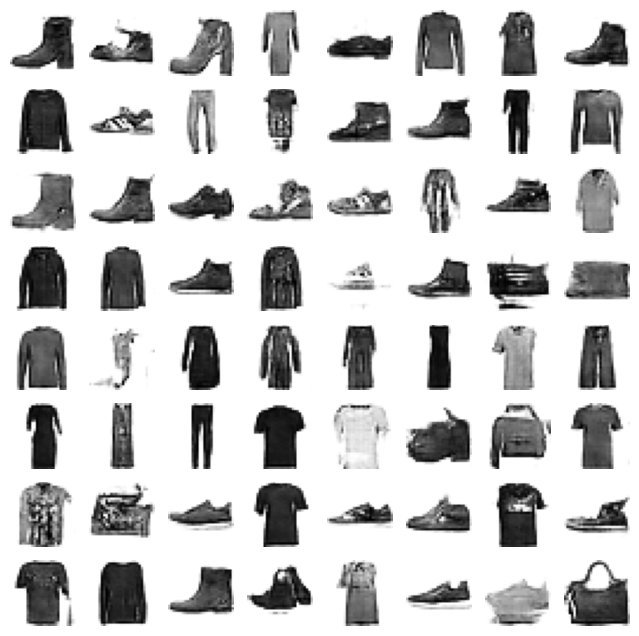

In [23]:
train(train_dataset, EPOCHS)


### Reconstrucción y Evaluación

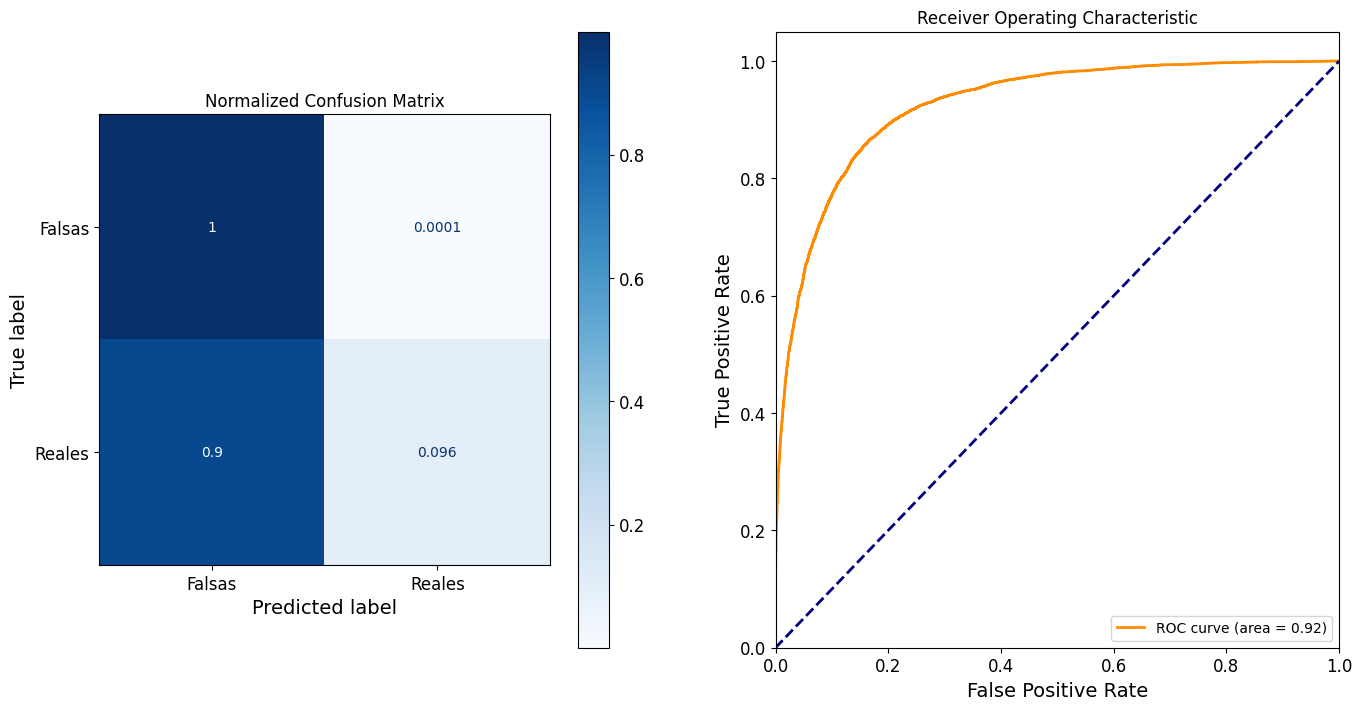

Precision: 0.9990
Recall: 0.0960
F2-score: 0.1172
              precision    recall  f1-score   support

      Falsas       0.53      1.00      0.69     10000
      Reales       1.00      0.10      0.18     10000

    accuracy                           0.55     20000
   macro avg       0.76      0.55      0.43     20000
weighted avg       0.76      0.55      0.43     20000



In [26]:
evaluate_discriminator(test_images, generator, discriminator, noise_dim)

# Conclusiones

Autoencoder regularizado: con el objetivo de mejorar la estabilidad y el rendimiento durante el entrenamiento. A partir del análisis de las curvas de pérdida (loss), se observó que la aplicación de técnicas de regularización suaviza considerablemente las curvas de entrenamiento en comparación con un autoencoder sin regularización. Esto no solo indica una mayor estabilidad durante el proceso de optimización, sino también una reducción en la varianza de la pérdida, lo que contribuye a una convergencia más confiable.

Mdelos Generative Adversarial Networks (GANs): se evidenció una notoria complejidad inherente al modelo, la cual se intentó manejar al máximo mediante la aplicación de los tips de entrenamiento. A pesar de esta complejidad, se observó que los GANs son significativamente más versátiles a la hora de generar datos en comparación con los autoencoders variacionales (VAE). Mientras que en los VAE es necesario ajustar cuidadosamente los términos de regularización o reconstrucción para lograr un buen balance entre la generación y la precisión de la reconstrucción, los GANs, aunque más complejos, ofrecen una mayor flexibilidad en la generación de datos sin requerir tales ajustes específicos.